# <center>Projet Topic Modeling</center>

During the Natural Language Processing course, text representation algorithms have been introduced. However they don't suffice to the creation of complete NLP systems.

Most of them usually rely on text pre-processing at first -- in other words, they rely on a specific data pipeline that is tied to the final task you are trying to solve.

As a result, we will try in this notebook to create a pipeline from scratch given a specific final task.

# Exploring the dataset

In [1]:
import pandas as pd
import numpy as np
import nltk

import pyLDAvis
import itertools
import itertools
import os
import re
import secrets
import string
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gensim
import gensim.corpora as corpora
import gensim.corpora as corpora
import pandas as pd
import spacy
import plotly.graph_objs as go
import plotly.express as px

from matplotlib import style
from sklearn.cluster import MiniBatchKMeans
from itertools import chain

from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, Phrases, KeyedVectors
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

from nltk.corpus import wordnet
from nltk.corpus import stopwords

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.metrics import silhouette_score

from tqdm import tqdm

from wordcloud import WordCloud

from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.kmeans import kmeans_observer
from pyclustering.cluster.kmeans import kmeans_visualizer

from spacy.parts_of_speech import IDS as POS_map

C:\Logiciels\Anaconda\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Logiciels\Anaconda\lib\site-packages\h5py\__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


You can load the dataset using pandas and the [.read_json()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html) method. Try loading your dataset here:

In [2]:
dataset = pd.read_json("News_Category_Dataset_v2.json", lines=True, dtype={"headline": str})

------

A good way to get the grasp of your corpus is to count the occurences of words across it. For convenience, we've defined a dummy function that splits words by checking where spaces are and... Simply that. This is the most basic form of word identification in text that could be used.

In [3]:
def dummy_word_split(texts):
    """Function identifying words in a sentence in a really dummy way.
        
        Argument:
            - texts (list of str): a list of raw texts in which we'd like to identify words
            
        Return:
            - list of list containing each word separately.
    """
    texts_out = []
    for text in texts:
        texts_out.append(text.split(" "))
        
    return texts_out

In [4]:
splitted_texts = dummy_word_split(dataset["headline"].tolist())

In [5]:
splitted_texts[0] + splitted_texts[1]

['There',
 'Were',
 '2',
 'Mass',
 'Shootings',
 'In',
 'Texas',
 'Last',
 'Week,',
 'But',
 'Only',
 '1',
 'On',
 'TV',
 'Will',
 'Smith',
 'Joins',
 'Diplo',
 'And',
 'Nicky',
 'Jam',
 'For',
 'The',
 '2018',
 'World',
 "Cup's",
 'Official',
 'Song']

Now, let's define a function that counts word occurences and highlight what are the most important words of our corpus:

In [6]:
def compute_word_occurences(texts):
    """You have to define this function yourself. """
    
    words = itertools.chain.from_iterable(texts)
    
    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})

    return word_count

Once this is done, display the top 20 most occuring words in your texts.

In [7]:
compute_word_occurences(splitted_texts).head(1000)

,Word,Count
0,The,47803
1,To,38569
2,A,24839
3,In,24141
4,Of,22956
...,...,...
995,Father's,258
996,Netflix,258
997,Park,258
998,Culture,257


Does it make sense, and can you leverage such results?

# Actual pipeline

As you have seen above, the results obtained from a simple word count aren't so great. Similar words doesn't add up (such as run and running), and you have a lot of noise included. Words such as *the*, *you*, *an* could be removed for instance.

Actually, a lot can be done. Let's check that out.

----------

## What does the pipeline look like?

A NLP data pipeline often relies on the following elements. Some can be added, some can be removed, but they all look like this at some point:

1. **Ensuring data quality.** You have to make sure that there's no N/A in your data and that everything is in the good format shape. Having this as the entrance of your pipeline will save you a lot of time in the long run, so try defining it thoroughly.


2. **Filtering texts from unwanted characters**. Especially if you get data from web, you'll end up with HTML tags or encoding stuff that you don't need in your texts. Before applying anything to them, you need to get them cleaned up. Here, try removing the dates and the punctuation for instance.


3. **Unify your texts**. (*This is topic modeling specific*). You don't want to make the difference between a word at the beginning of a phrase of in the middle of it here. You should unify all your words by lowercasing them and deaccenting them as well.


4. **Converting sentences to lists of words**. Some words aren't needed for our analyses, such as *your*, *my*, etc. In order to remove them easily, you have to convert your sentences to lists of words. You can use the dummy function defined above but I'd advised against it. Try finding a function that does that smoothly in [gensim.utils](https://radimrehurek.com/gensim/utils.html)!


5. **Remove useless words**. You need to remove useless words from your corpus. You have two approaches: [use a hard defined list of stopwords](https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/) or rely on TF-IDF to identify useless words. The first is the simplest, the second might yield better results!


6. **Creating n-grams**. If you look at New York, it is composed of two words. As a result, a word count wouldn't really return a true count for *New York* per se. In NLP, we represent New York as New_York, which is considered a single word. The n-gram creation consists in identifying words that occur together often and regrouping them. It boosts interpretability for topic modeling in this case.


7. **Stemming / Lemmatization**. Shouldn't run, running, runnable be grouped and counted as a single word when we're identifying discussion topics? Yes, they should. Stemming is the process of cutting words to their word root (run- for instance) quite brutally while lemmatization will do the same by identifying the kind of word it is working on. You should convert the corpus words into those truncated representations to have a more realistic word count.


8. **Part of speech tagging**. POS helps in the identification of verbs, nouns, adjectives, etc. For topic models, it is a good idea to work only on verbs and nouns. Adjectives don't convey info about the actual underlying topic discussed at hand.

## Let's create it!

Now it's your turn. Try to implement each step of the pipeline, and compare the word counts obtained earlier and the one obtained after preprocessing your texts.

### Ensuring data quality

In [8]:
def check_data_quality(texts):
    """Check wheter all the dataset is conform to the expected behaviour."""
    assert all([isinstance(t, str) for t in texts]), "Input data contains something different than strings."
    assert all([t != np.nan for t in texts]), "Input data contains NaN values."
    
    return True

In [9]:
def force_format(texts):
    return [str(t) for t in texts]

In [10]:
texts = force_format(dataset["headline"])

In [11]:
print(f"Is the dataset passing our data quality check?\n{check_data_quality(texts)}")

Is the dataset passing our data quality check?
True


### Filtering texts

https://regex101.com/

In [12]:
def filter_text(texts_in):
    """Removes incorrect patterns from a list of texts, such as hyperlinks, bullet points and so on"""
    
    texts_out = re.sub(r'https?:\/\/[A-Za-z0-9_.-~\-]*', ' ', texts_in, flags=re.MULTILINE)
    texts_out = re.sub(r'[(){}\[\]<>]', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&amp;#.*;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&gt;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'â€™', "'", texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'\s+', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&#x200B;', ' ', texts_out, flags=re.MULTILINE)
    # Mail regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r"(?i)(?:[a-z0-9!#$%&'*+\/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+\/=?^_`{|}~-]+)*|\"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*\")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+\.[a-zA-Z0-9-_.]+', '', texts_out, flags=re.MULTILINE)
    # Phone regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r".*?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}).*?", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r"\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}", '', texts_out, flags=re.MULTILINE)
    # Remove names in twitter
    texts_out = re.sub(r'@\S+( |\n)', '', texts_out, flags=re.MULTILINE)

    # Remove starts commonly used on social media
    texts_out = re.sub(r'\*', '', texts_out, flags=re.MULTILINE)
    return texts_out


In [13]:
texts = [filter_text(t) for t in texts]

### Unifying texts & converting sentences to list of words

In [14]:
def sent_to_words(sentences):
    """Converts sentences to words.

    Convert sentences in lists of words while removing the accents and the punctuation.

    @param:
        sentences: a list of strings, the sentences we want to convert
    @return
        A list of words' lists.
    """
    for sentence in tqdm(sentences):
        yield (simple_preprocess(str(sentence), deacc=True))


In [15]:
texts = list(sent_to_words(texts))

100%|███████████████████████████████████████████████████████████████████████| 200853/200853 [00:05<00:00, 35438.77it/s]


In [16]:
texts

[['there',
  'were',
  'mass',
  'shootings',
  'in',
  'texas',
  'last',
  'week',
  'but',
  'only',
  'on',
  'tv'],
 ['will',
  'smith',
  'joins',
  'diplo',
  'and',
  'nicky',
  'jam',
  'for',
  'the',
  'world',
  'cup',
  'official',
  'song'],
 ['hugh', 'grant', 'marries', 'for', 'the', 'first', 'time', 'at', 'age'],
 ['jim',
  'carrey',
  'blasts',
  'castrato',
  'adam',
  'schiff',
  'and',
  'democrats',
  'in',
  'new',
  'artwork'],
 ['julianna',
  'margulies',
  'uses',
  'donald',
  'trump',
  'poop',
  'bags',
  'to',
  'pick',
  'up',
  'after',
  'her',
  'dog'],
 ['morgan',
  'freeman',
  'devastated',
  'that',
  'sexual',
  'harassment',
  'claims',
  'could',
  'undermine',
  'legacy'],
 ['donald',
  'trump',
  'is',
  'lovin',
  'new',
  'mcdonald',
  'jingle',
  'in',
  'tonight',
  'show',
  'bit'],
 ['what',
  'to',
  'watch',
  'on',
  'amazon',
  'prime',
  'that',
  'new',
  'this',
  'week'],
 ['mike',
  'myers',
  'reveals',
  'he',
  'like',
  'to',

## Remove useless words

In [17]:
en_stops = set(stopwords.words('english'))

## TF-IDF pour identifier les stopwords
tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words=en_stops, ngram_range=(1,1))
tvec_weights = tvec.fit_transform(dataset['headline'].dropna())
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

## Liste pré-définis de stopwords à éliminer
for lists in texts:
    for word in en_stops:
        try:
            lists.remove(word)
        except Exception as e:
            e =""

### COMPTER LES MOTS A LA FIN DES DEUX METHODES ET LES COMPARER

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
texts

[['mass', 'shootings', 'texas', 'last', 'week', 'tv'],
 ['smith',
  'joins',
  'diplo',
  'nicky',
  'jam',
  'world',
  'cup',
  'official',
  'song'],
 ['hugh', 'grant', 'marries', 'first', 'time', 'age'],
 ['jim',
  'carrey',
  'blasts',
  'castrato',
  'adam',
  'schiff',
  'democrats',
  'new',
  'artwork'],
 ['julianna',
  'margulies',
  'uses',
  'donald',
  'trump',
  'poop',
  'bags',
  'pick',
  'dog'],
 ['morgan',
  'freeman',
  'devastated',
  'sexual',
  'harassment',
  'claims',
  'could',
  'undermine',
  'legacy'],
 ['donald',
  'trump',
  'lovin',
  'new',
  'mcdonald',
  'jingle',
  'tonight',
  'show',
  'bit'],
 ['watch', 'amazon', 'prime', 'new', 'week'],
 ['mike', 'myers', 'reveals', 'like', 'fourth', 'austin', 'powers', 'film'],
 ['watch', 'hulu', 'new', 'week'],
 ['justin', 'timberlake', 'visits', 'texas', 'school', 'shooting', 'victims'],
 ['south',
  'korean',
  'president',
  'meets',
  'north',
  'korea',
  'kim',
  'jong',
  'un',
  'talk',
  'trump',
  'su

### Creating n-grams

In [19]:
def create_bigrams(texts, bigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify bigrams in texts and return the texts with bigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))
    
    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))
    
    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]

def create_trigrams(texts, trigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify trigrams in texts and return the texts with trigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))
    
    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))
    
    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]


In [20]:
texts = create_bigrams(texts)

In [21]:
texts

['mass_shootings texas last week tv',
 'smith joins diplo nicky jam world_cup official song',
 'hugh grant marries first_time age',
 'jim_carrey blasts castrato adam schiff democrats new artwork',
 'julianna margulies uses donald_trump poop bags pick dog',
 'morgan_freeman devastated sexual_harassment claims could undermine legacy',
 'donald_trump lovin new mcdonald jingle tonight_show bit',
 'watch amazon prime new week',
 'mike myers reveals like fourth austin powers film',
 'watch hulu new week',
 'justin_timberlake visits texas school_shooting victims',
 'south_korean president meets north_korea kim_jong un talk trump summit',
 'way life risk remote oyster growing region called robots',
 'trump crackdown immigrant parents puts kids already strained system',
 'trump son concerned fbi obtained wiretaps putin ally met trump_jr',
 'edward_snowden one trump loves vladimir_putin',
 'booyah obama photographer hilariously trolls trump spy claim',
 'ireland votes repeal abortion amendment l

### Stemming / Lemmatization & Part-of-Speech filtering

In [22]:
def lemmatize_texts(texts, 
                    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], 
                    forbidden_postags=[], 
                    as_sentence=False, 
                    get_postags=False, 
                    spacy_model=None):
    """Lemmatize a list of texts.
    
            Please refer to https://spacy.io/api/annotation for details on the allowed
        POS tags.
        @params:
            - texts_in: a list of texts, where each texts is a string
            - allowed_postags: a list of part of speech tags, in the spacy fashion
            - as_sentence: a boolean indicating whether the output should be a list of sentences instead of a list of word lists
        @return:
            - A list of texts where each entry is a list of words list or a list of sentences
        """
    texts_out = []
    
    if allowed_postags and forbidden_postags:
        raise ValueError("Can't specify both allowed and forbidden postags")

    if forbidden_postags:
        allowed_postags = list(set(POS_map.keys()).difference(set(forbidden_postags)))

    if not spacy_model:
        print("Loading spacy model")
        spacy_model = spacy.load('en_core_web_md')

    print("Beginning lemmatization process")
    total_steps = len(texts)

    docs = spacy_model.pipe(texts)

    for i, doc in tqdm(enumerate(docs), total=total_steps):
        if get_postags:
            texts_out.append(["_".join([token.lemma_, token.pos_]) for token in doc if token.pos_ in allowed_postags])
        else:
            texts_out.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    if as_sentence:
        texts_out = [" ".join(text) for text in texts_out]
        
    return texts_out

In [23]:
l_texts = lemmatize_texts(texts[:1000],
                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'X', 'PROPN'], 
                get_postags=False)

Loading spacy model
Beginning lemmatization process


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 564.01it/s]


## Vectorisation

In [24]:
# Passage d'une liste de liste de mot à une liste de string
# Cela permettra de transformer notre corpus 
str1 = ""
vectorized_texts = l_texts

for text in vectorized_texts:
    str1 += " ".join(text)
    str1 += " /£$/ " 
vectorized_texts = str1.split(" /£$/ ")

vect = TfidfVectorizer(stop_words='english', max_features=1000)
vect_text = vect.fit_transform(vectorized_texts)
print(vect_text.shape)

(1001, 1000)


In [25]:
vect_text

<1001x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4491 stored elements in Compressed Sparse Row format>

## KMeans

On va créer une fonction qui permet de trouver le nombre de cluster optimal. 
On affichera une graphique du nombre de cluster en fonction de SSE (la somme de l'erreur au carré / l'inertie). 

### KMeans - Métriques de clustering

#### Davies Bouldin Score

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 5, Davies Bouldin Score is 5.9773930849282575


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 7, Davies Bouldin Score is 5.856275126102056


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 9, Davies Bouldin Score is 5.707922337779802


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 11, Davies Bouldin Score is 7.221573331858162


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 13, Davies Bouldin Score is 5.317370028775342


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 15, Davies Bouldin Score is 6.687474380927684


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 17, Davies Bouldin Score is 5.092981505402058


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 19, Davies Bouldin Score is 5.876292902844751


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 21, Davies Bouldin Score is 4.877117988876561


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 23, Davies Bouldin Score is 5.615257891954147


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 25, Davies Bouldin Score is 5.288191225606664


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 27, Davies Bouldin Score is 5.447725759148646


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 29, Davies Bouldin Score is 4.5751838548894685


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 31, Davies Bouldin Score is 5.124955938499047


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 33, Davies Bouldin Score is 5.095231468793403


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 35, Davies Bouldin Score is 5.143587993748209


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 37, Davies Bouldin Score is 5.019527993439899


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 39, Davies Bouldin Score is 5.020466945998507


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 41, Davies Bouldin Score is 4.882857878997519
For n_clusters = 43, Davies Bouldin Score is 4.865404730712704


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Text(0.5, 1.0, 'Davies Bouldin Score by Cluster Center Plot')

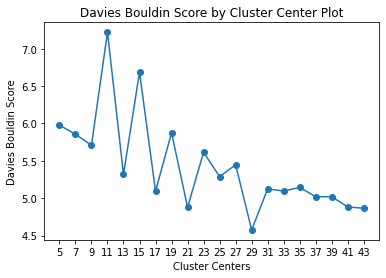

In [26]:
# Davies Bouldin Score
kmeans_text = vect_text

iters = range(5, 45, 2)
db = []
for n_clusters in iters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(kmeans_text)
    centers = clusterer.cluster_centers_

    score = davies_bouldin_score(kmeans_text.todense(), preds)
    db.append(score)
    print("For n_clusters = {}, Davies Bouldin Score is {}".format(n_clusters, score))
        
f, ax = plt.subplots(1, 1)
ax.plot(iters, db, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(iters)
ax.set_xticklabels(iters)
ax.set_ylabel('Davies Bouldin Score')
ax.set_title('Davies Bouldin Score by Cluster Center Plot')

#### Calinski Harabasz Score

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 5, Calinski Harabasz score is 5.8340574802276866


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 7, Calinski Harabasz score is 5.569907763999734


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 9, Calinski Harabasz score is 5.384185839902214


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 11, Calinski Harabasz score is 4.898187040491638


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 13, Calinski Harabasz score is 4.649520662045853


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 15, Calinski Harabasz score is 4.392965473569894


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 17, Calinski Harabasz score is 4.237844551854593


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 19, Calinski Harabasz score is 4.179597331273341


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 21, Calinski Harabasz score is 3.962082238241904


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 23, Calinski Harabasz score is 3.946629168888116


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 25, Calinski Harabasz score is 3.6350162905605776


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 27, Calinski Harabasz score is 3.8362210665499834


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 29, Calinski Harabasz score is 3.6424342647064796


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 31, Calinski Harabasz score is 3.641976705916146


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 33, Calinski Harabasz score is 3.5100936819934194


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 35, Calinski Harabasz score is 3.4014021563326393


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 37, Calinski Harabasz score is 3.254447242436458


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 39, Calinski Harabasz score is 3.3278730185683734


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 41, Calinski Harabasz score is 3.198730641582767


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 43, Calinski Harabasz score is 3.0390085559805042


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 45, Calinski Harabasz score is 3.0950183582580544


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 47, Calinski Harabasz score is 3.072276991303684
For n_clusters = 49, Calinski Harabasz score is 3.1034219303077446


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Text(0.5, 1.0, 'Calinski Harabasz Score by Cluster Center Plot')

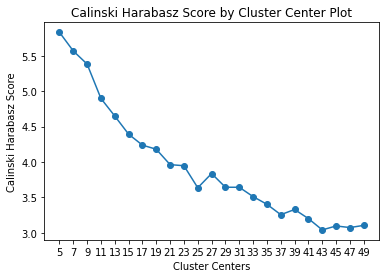

In [27]:
# Calinski Harabasz Score
kmeans_text = vect_text

iters = range(5, 50, 2)
calinski = []
for n_clusters in iters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(kmeans_text)
    centers = clusterer.cluster_centers_

    score = calinski_harabasz_score(kmeans_text.todense(), preds)
    calinski.append(score)
    print("For n_clusters = {}, Calinski Harabasz score is {}".format(n_clusters, score))
        
f, ax = plt.subplots(1, 1)
ax.plot(iters, calinski, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(iters)
ax.set_xticklabels(iters)
ax.set_ylabel('Calinski Harabasz Score')
ax.set_title('Calinski Harabasz Score by Cluster Center Plot')

#### Silhouette Score

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 5, silhouette score is 0.010457414079656318


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 7, silhouette score is 0.010835118084585581


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 9, silhouette score is 0.012997176598441976


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 11, silhouette score is 0.013429974456578612


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 13, silhouette score is 0.014256083056603502


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 15, silhouette score is 0.01529315124313656


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 17, silhouette score is 0.01684682605843687


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 19, silhouette score is 0.018832799000555563


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 21, silhouette score is 0.018760640357755928


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 23, silhouette score is 0.01986943231734279


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 25, silhouette score is 0.02019821758601132


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 27, silhouette score is 0.019585556531712397


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 29, silhouette score is 0.020420584132071366


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 31, silhouette score is 0.02298466495309086


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 33, silhouette score is 0.025069333811634384


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 35, silhouette score is 0.022212174428770434


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 37, silhouette score is 0.024305296991677692


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 39, silhouette score is 0.02339763449615038


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 41, silhouette score is 0.02540328493911517


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 43, silhouette score is 0.025763105577448


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 45, silhouette score is 0.025429577519064564


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 47, silhouette score is 0.026973495040524393
For n_clusters = 49, silhouette score is 0.027870381442559756


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Text(0.5, 1.0, 'silhouette score by Cluster Center Plot')

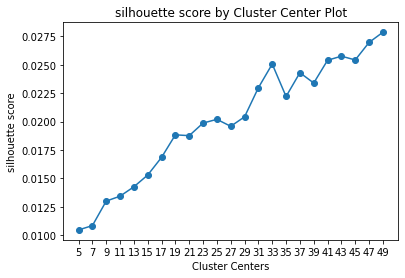

In [28]:
# Silhouette score
kmeans_text = vect_text

iters = range(5, 50, 2)
silhouette = []
for n_clusters in iters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(kmeans_text)
    centers = clusterer.cluster_centers_

    score = silhouette_score(kmeans_text.todense(), preds)
    silhouette.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))
        
f, ax = plt.subplots(1, 1)
ax.plot(iters, silhouette, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(iters)
ax.set_xticklabels(iters)
ax.set_ylabel('silhouette score')
ax.set_title('silhouette score by Cluster Center Plot')

Les métriques Calinski-Harabaz et silhouette score ne permettent pas de déterminer le nombre optimal de sujets. Plus le nombre de sujets augmente, plus les valeurs de ces métriques diminuent, ce qui signifie que les clusters deviennent moins bons du point de vue de ces métriques. La métrique cDBI se comporte différemment en fonction du nombre de sujets.

### KMeans - Visualisation de données

No handles with labels found to put in legend.


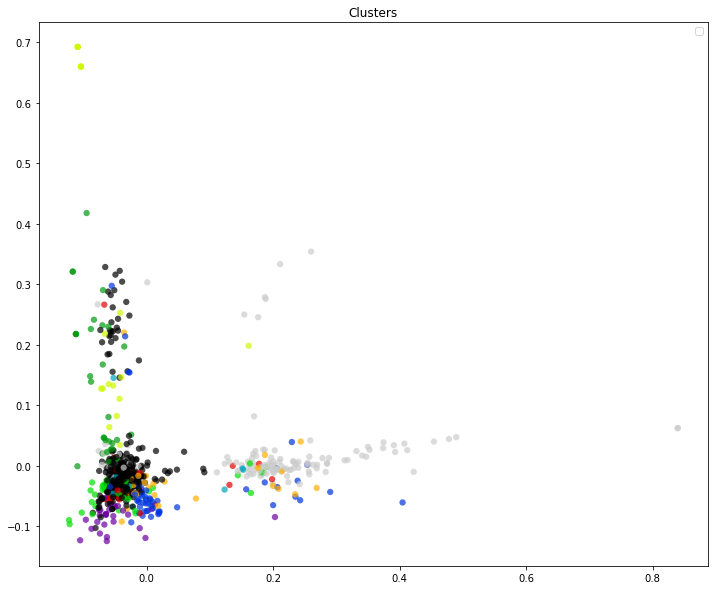

In [29]:
kmeans = KMeans(n_clusters=13,random_state=42)
y_kmeans = kmeans.fit_predict(vect_text.toarray())

from sklearn.decomposition import PCA

X_pca = PCA(2).fit_transform(vect_text.toarray())

plt.figure(figsize=(12,10))
plt.scatter(X_pca[:,0],X_pca[:,1], c=y_kmeans, edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.title("Clusters")
plt.legend()
plt.show()

## Latent Dirichlet Allocation

Nous allons utiliser LDA qui est un type de Machine Learning non supervisé (ce qu'on recherche dans notre cas).

L'objectif est de récupérer les paramètres des distributions dirichlet qui représentent la distribution des sujets dans les documents et la distribution des mots dans les sujets.

### LDA - Métrique de clustering

In [30]:
# Creation du dictionnaire 
id2word = corpora.Dictionary(l_texts)
# Creation du corpus
texts = l_texts
# Fréquence des termes du document
corpus = [id2word.doc2bow(text) for text in texts]

In [31]:
# Construction du modèle LDA
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [32]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=l_texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6235367897508647


Notre approche pour trouver le nombre optimal de sujets consiste à construire de nombreux modèles LDA avec différentes valeurs du nombre de sujets (k) et à choisir celui qui donne la valeur de cohérence la plus élevée.

Le choix d'un 'k' qui marque la fin d'une croissance rapide de la cohérence des sujets offre généralement des sujets significatifs et interprétables. Le choix d'une valeur encore plus élevée peut parfois fournir des sous-thèmes plus granulaires.

Si vous voyez les mêmes mots-clés répétés dans plusieurs sujets, c'est probablement un signe que le 'k' est trop grand.
La fonction compute_coherence_values() (voir ci-dessous) entraîne plusieurs modèles LDA et fournit les modèles et leurs scores de cohérence correspondants.

#### Cohérence score

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=l_texts, start=2, limit=40, step=6)

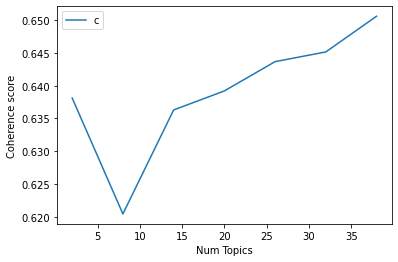

In [35]:
# Affichage du graphe

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Affichage des scores de cohérence
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6381
Num Topics = 8  has Coherence Value of 0.6204
Num Topics = 14  has Coherence Value of 0.6363
Num Topics = 20  has Coherence Value of 0.6392
Num Topics = 26  has Coherence Value of 0.6437
Num Topics = 32  has Coherence Value of 0.6451
Num Topics = 38  has Coherence Value of 0.6506


On voit qu'à partir de 32 topics, la cohérence diminue donc on peut considérer que pour ce modèle, 32 topics est l'idéal.

### LDA - Visualisation des données

In [37]:
vect = CountVectorizer(stop_words='english')
vect_text = vect.fit_transform(vectorized_texts)
print(vect_text.shape)

(1001, 3077)


In [38]:
# Tweak the two parameters below
number_topics = 20
number_words = 8

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1, learning_decay=0.9)
lda.fit(vect_text)


import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = pyLDAvis.sklearn.prepare(lda, vect_text, vect, mds='tsne')
lda_viz

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Logiciels\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances'

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
0      -10.878068   10.538728       1        1  8.348592
12     -60.884026  -75.591820       2        1  6.786168
11      -2.336119  -53.289074       3        1  6.193976
8      -61.385319  -12.914634       4        1  5.658544
3      -28.737743  126.296997       5        1  5.525171
15       1.066606 -123.552811       6        1  5.388022
17      45.140720   -7.947869       7        1  5.201744
6     -140.795975  -98.530548       8        1  5.119131
5       61.531681  -83.240562       9        1  4.954444
9      -72.563057 -140.396881      10        1  4.897014
13      15.984491   63.578186      11        1  4.866299
7     -160.851624   68.945145      12        1  4.574898
10      85.961830   51.922935      13        1  4.515689
18     -99.020836  109.936348      14        1  4.413148
16    -176.764130   -8.681684      15        1  4.393777
2     -117.189880  -37.420200      16        1  4.365531
1      108.829918  -22.946203      17        1  4.216235
19      47.588097  121.934814      18        1  3.904631
4     -106.467834   30.176889      19        1  3.520594
14     -50.613804   59.328842      20        1  3.156391, topic_info=              Term        Freq       Total Category  logprob  loglift
2416           say   47.000000   47.000000  Default   30.000  30.0000
2865         trump  104.000000  104.000000  Default   29.000  29.0000
2428  schneiderman    7.000000    7.000000  Default   28.000  28.0000
890           eric    7.000000    7.000000  Default   27.000  27.0000
3038         woman   20.000000   20.000000  Default   26.000  26.0000
...            ...         ...         ...      ...      ...      ...
2112        praise    0.642929    3.330035  Topic20   -5.803   1.8110
1919         offer    0.642929    5.391710  Topic20   -5.803   1.3292
988           film    0.642929    5.561285  Topic20   -5.803   1.2982
1652          male    0.642929    2.680897  Topic20   -5.803   2.0279
2951         video    0.642929    8.285571  Topic20   -5.803   0.8995

[1238 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4         1  0.281774  abortion
4         2  0.140887  abortion
4         3  0.140887  abortion
4         4  0.140887  abortion
4        12  0.140887  abortion
...     ...       ...       ...
3069      6  0.239353     young
3069     15  0.239353     young
3069     17  0.239353     young
3072     20  0.773000     zinke
3076     13  0.739232       zoo

[2522 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 13, 12, 9, 4, 16, 18, 7, 6, 10, 14, 8, 11, 19, 17, 3, 2, 20, 5, 15])

## Hierarchical Clustering: Agglomerative algorithms

Cette technique est basée sur la "fusion" des points de données individuels qui sont proches les uns des autres pour former des groupes plus grands, jusqu'à ce que le nombre donné de clusters (paramètre n_clusters) soit atteint.

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 5, Silhouette score is 0.010538782397892498


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 7, Silhouette score is 0.00011662367706208568


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 9, Silhouette score is -0.009027885926281802


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 11, Silhouette score is -0.006427775252897944


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 13, Silhouette score is -0.004748690180021585


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 15, Silhouette score is -0.002835274521133324


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 17, Silhouette score is -0.0011375097120904674


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 19, Silhouette score is -7.041842343431852e-05


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 21, Silhouette score is 0.0014581304787665607


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 23, Silhouette score is 0.002785615871810698


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 25, Silhouette score is 0.0007057221586072191


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 27, Silhouette score is -0.05443602323225017


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 29, Silhouette score is -0.05304739482729381


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 31, Silhouette score is -0.051647805522573115


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 33, Silhouette score is -0.050230879507364726


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 35, Silhouette score is -0.0485147084036235


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 37, Silhouette score is -0.04743942245310047


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 39, Silhouette score is -0.04625698543829865


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 41, Silhouette score is -0.045037962429705536


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 43, Silhouette score is -0.044042569402092335


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 45, Silhouette score is -0.04275717908763587


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 47, Silhouette score is -0.0415969805738999


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 49, Silhouette score is -0.04049433252670977


Text(0.5, 1.0, 'Silhouette Score by Cluster Center Plot')

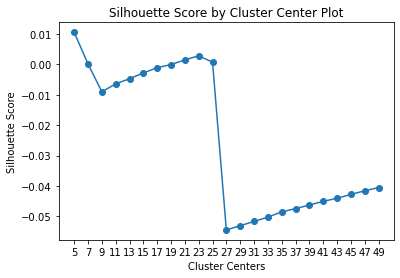

In [39]:
# Silhouette Score
ac_text = vect_text

iters = range(5, 50, 2)
silhouette = []
for n_clusters in iters:
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    preds = ac.fit_predict(ac_text.todense())

    score = silhouette_score(ac_text, preds)
    silhouette.append(score)
    print("For n_clusters = {}, Silhouette score is {}".format(n_clusters, score))
        
f, ax = plt.subplots(1, 1)
ax.plot(iters, silhouette, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(iters)
ax.set_xticklabels(iters)
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score by Cluster Center Plot')

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 5, Calinski Harabasz Score is 6.587334658004021


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 7, Calinski Harabasz Score is 5.775283161290203


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 9, Calinski Harabasz Score is 5.260563716736681


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 11, Calinski Harabasz Score is 4.933772890663728


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 13, Calinski Harabasz Score is 4.676003623443104


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 15, Calinski Harabasz Score is 4.463417745553073


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 17, Calinski Harabasz Score is 4.2842104140817865


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 19, Calinski Harabasz Score is 4.12979264425901


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 21, Calinski Harabasz Score is 3.9889634199828756


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 23, Calinski Harabasz Score is 3.868363163935722


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 25, Calinski Harabasz Score is 3.7639225509605683


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 27, Calinski Harabasz Score is 3.6735915942865267
For n_clusters = 29, Calinski Harabasz Score is 3.589694313237594


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Text(0.5, 1.0, 'Calinski Harabasz Score by Cluster Center Plot')

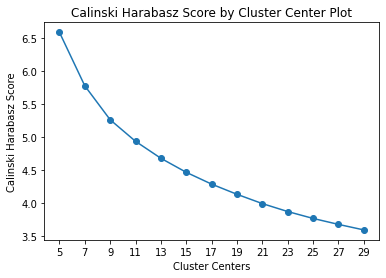

In [40]:
# Calinski Harabasz Score
ac_text = vect_text

iters = range(5, 30, 2)
calinski = []
for n_clusters in iters:
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    preds = ac.fit_predict(ac_text.todense())

    score = calinski_harabasz_score(ac_text.todense(), preds)
    calinski.append(score)
    print("For n_clusters = {}, Calinski Harabasz Score is {}".format(n_clusters, score))
        
f, ax = plt.subplots(1, 1)
ax.plot(iters, calinski, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(iters)
ax.set_xticklabels(iters)
ax.set_ylabel('Calinski Harabasz Score')
ax.set_title('Calinski Harabasz Score by Cluster Center Plot')

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 5, Davies Bouldin Score is 6.273572116171146


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 7, Davies Bouldin Score is 5.465570352416293


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 9, Davies Bouldin Score is 4.729512735108147


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 11, Davies Bouldin Score is 5.590761311434752


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 13, Davies Bouldin Score is 5.213756549904813


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 15, Davies Bouldin Score is 4.941273393109113


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 17, Davies Bouldin Score is 4.7468321373916655


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 19, Davies Bouldin Score is 4.5967362348217025


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 21, Davies Bouldin Score is 4.8011133336242455


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 23, Davies Bouldin Score is 4.921241114999472


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 25, Davies Bouldin Score is 4.763180914459952


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


For n_clusters = 27, Davies Bouldin Score is 4.73746288929662
For n_clusters = 29, Davies Bouldin Score is 4.596885388260798


C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Text(0.5, 1.0, 'Davies Bouldin Score by Cluster Center Plot')

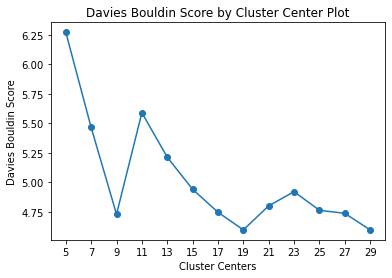

In [41]:
# Davies Bouldin Score
db_text = vect_text

iters = range(5, 30, 2)
db = []
for n_clusters in iters:
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    preds = ac.fit_predict(db_text.todense())

    score = davies_bouldin_score(db_text.todense(), preds)
    db.append(score)
    print("For n_clusters = {}, Davies Bouldin Score is {}".format(n_clusters, score))
        
f, ax = plt.subplots(1, 1)
ax.plot(iters, db, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(iters)
ax.set_xticklabels(iters)
ax.set_ylabel('Davies Bouldin Score')
ax.set_title('Davies Bouldin Score by Cluster Center Plot')

## Comparaison des modèles

Ci-dessous va être affichés les différents scores de chaque métrique pour les modèles optimaux.

In [42]:
# Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=15)
preds = ac.fit_predict(ac_text.todense())

# KMeans
clusterer = KMeans(n_clusters=15)
preds = clusterer.fit_predict(kmeans_text)

# LDA
lda = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=20, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

silhouette_score_ac = silhouette_score(ac_text, preds)
davies_bouldin_score_ac = davies_bouldin_score(ac_text.todense(), preds)
calinski_harabasz_score_ac = calinski_harabasz_score(ac_text.todense(), preds)

silhouette_score_km = silhouette_score(kmeans_text, preds)
davies_bouldin_score_km = davies_bouldin_score(kmeans_text.todense(), preds)
calinski_harabasz_score_km = calinski_harabasz_score(kmeans_text.todense(), preds)

coherencemodel = CoherenceModel(model=lda, texts=l_texts, dictionary=id2word, coherence='c_v')
coherence_score_lda = coherencemodel.get_coherence()

print('Silhouette Score AC :', silhouette_score_ac)
print('Silhouette Score KMeans :', silhouette_score_km)
print('Davies Bouldin Score AC :', davies_bouldin_score_ac)
print('Davies Bouldin Score KMeans :', davies_bouldin_score_ac)
print('Calinski Harabasz Score AC :', calinski_harabasz_score_ac)
print('Calinski Harabasz Score KMeans :', calinski_harabasz_score_km)
print('Coherence Score LDA :', coherence_score_lda)

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Logiciels\Anaconda\lib\site-packages\skl

Silhouette Score AC : -0.0425528506926512
Silhouette Score KMeans : 0.014740271347302077
Davies Bouldin Score AC : 6.436557146638805
Davies Bouldin Score KMeans : 6.436557146638805
Calinski Harabasz Score AC : 4.401079892369139
Calinski Harabasz Score KMeans : 4.235512453440431
Coherence Score LDA : 0.5989700843343848


In [43]:
ar = np.array([[1.1, 2, 3.3, 4], [2.7, 10, 5.4, 7], [5.3, 9, 1.5, 15]])
df = pd.DataFrame(ar, index = ['KMeans', 'Agglomerative Clustering', 'LDA'], 
                      columns = ['Silhouette Score', 'Calinski Harabasz Score', 'Davies Bouldin Score', 'Coherence Score'])
df

,Silhouette Score,Calinski Harabasz Score,Davies Bouldin Score,Coherence Score
KMeans,1.1,2.0,3.3,4.0
Agglomerative Clustering,2.7,10.0,5.4,7.0
LDA,5.3,9.0,1.5,15.0
